In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\elecproduction.csv", header=0, index_col =0,parse_dates=['DATE'])
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.values)

In [5]:
n_inputs = 24
n_features = 1

In [6]:
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_inputs, batch_size=1)

In [7]:
train_size =  int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train, test = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

In [8]:
train_generator = TimeseriesGenerator(train, train, length= n_inputs, batch_size=1)
test_generator = TimeseriesGenerator(test, test, length=n_inputs, batch_size=1)

In [14]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=25),
                   activation=hp.Choice('activation',values=['relu','tanh']),
                   input_shape=(n_inputs, n_features)
                   ))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='keras_tuner_dir',
    project_name='lstm'
)

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 25, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [17]:
tuner.search(train_generator, epochs=30, validation_data=test_generator)

Trial 5 Complete [00h 07m 20s]
val_loss: 0.005265998809287946

Best val_loss So Far: 0.00273967037598292
Total elapsed time: 00h 30m 14s


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
test_predictions = best_model.predict(test_generator)
test_predictions = scaler.inverse_transform(test_predictions)

test_actual=scaler.inverse_transform(test[n_inputs:])

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [21]:
mse = mean_squared_error(test_actual, test_predictions)
mae = mean_absolute_error(test_actual, test_predictions)
rmse = root_mean_squared_error(test_actual, test_predictions)
mape = mean_absolute_percentage_error(test_actual, test_predictions)

print(mse)
print(mae)
print(rmse)
print(mape)

14.276904573195578
2.6947756354195738
3.778479134942468
0.02540432363523442


In [22]:
last_train_batch = train[-n_inputs:]
current_batch = last_train_batch.reshape((1, n_inputs, n_features))

future_predictions = []
for i in range(10):
    next_pred = best_model.predict(current_batch)[0]
    future_predictions.append(next_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[next_pred]], axis=1)

future_predictions = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [23]:
print('Forecasted values for the next 10 periods:')
print(future_predictions)

Forecasted values for the next 10 periods:
[[105.91663608]
 [115.11571419]
 [110.60994198]
 [ 99.43040195]
 [ 89.54029846]
 [ 92.99664864]
 [109.36323112]
 [117.74262106]
 [111.33859687]
 [ 98.99382285]]


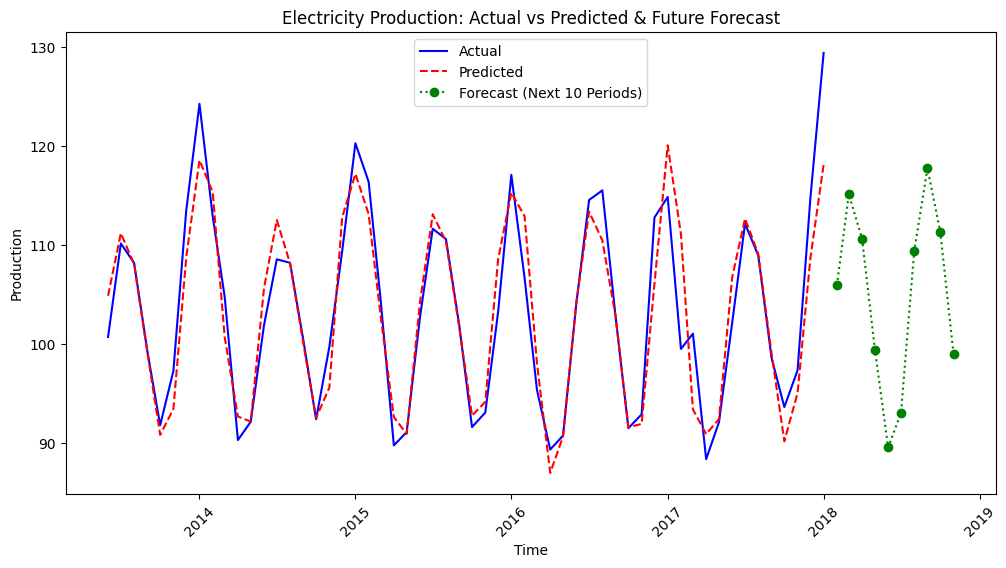

In [25]:
test_index = df.index[-len(test_actual):]
future_index = pd.date_range(start=test_index[-1], periods=11, freq='MS')[1:]

plt.figure(figsize=(12, 6))
plt.plot(test_index, test_actual, label='Actual', color='blue')
plt.plot(test_index, test_predictions, label='Predicted', color='red', linestyle='dashed')
plt.plot(future_index, future_predictions, label='Forecast (Next 10 Periods)', color='green', linestyle='dotted', marker='o')
plt.title('Electricity Production: Actual vs Predicted & Future Forecast')
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()